In [8]:
# import the libraries
import cv2
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [9]:
# initialize the constants: 
# Initial Learning Rate
# Epochs
# Batch Size
# Length 
# Width 
INITIAL_LEARINGRATE = .001
EPOCHS = 10
BATCH_SIZE = 32
LENGTH = 224
WIDTH = 224

Loading the Preprocessing the Data

In [10]:
# take the images and put them into lists
image_path = list(paths.list_images(r"C:\\Users\\usuik\\Documents\\Masters_Program\\AAI-501 Intro to AI\\AAI-501-Intro-to-AI\\DATA"))

In [11]:
# create empty list for the data and the labels
data = list()
labels = list()

In [12]:
# now we want to loop over all the images in the files and then rescale them to a 224x224 aspect ratio. This will be done via the CV library
for x in image_path:
    # getting the classlabel
    label = x.split(os.path.sep)[-2]

    # now, we load the image, change the color to RGB and then resize it
    image = cv2.imread(x)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(LENGTH,WIDTH))

    # update our label and data list
    labels.append(label)
    data.append(image)


In [13]:
# convert the data and labels to Numpy Arrays while scaling the pixel intensity
data = np.array(data) / 255.0 # 255 RGB colors
data.reshape(-1,1)
labels = np.array(labels)

Creating the Model using VGG16 Base Model

In [14]:
# one-hot encoding the models
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [15]:
# creating our train and test data. Using standard practice, 80% of the dataset will be used for training 
# while the 20% will be used for testing
trainX, testX, trainY, testY = train_test_split(data,labels,test_size=.2, stratify=labels,random_state=42)

In [16]:
# initialize the training data augmentation object
train_augment = ImageDataGenerator(
    rotation_range =15,
    fill_mode = 'nearest'
)

In [17]:
# load the base model
base_model = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(LENGTH,WIDTH,3)))

In [18]:
# create the head of the model that is going to be on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(64, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

In [19]:
# now we will create our model; this model will be the one that is used to do the trainings
model = Model(inputs=base_model.input, outputs=head_model)

In [20]:
# freeze the layers of the base model so its not updated during the first training process
for y in base_model.layers:
    y.trainable = False

Compiling the Model

In [21]:
# using the ADAM optimizer to optimize
optimizer = Adam(learning_rate=INITIAL_LEARINGRATE, weight_decay = INITIAL_LEARINGRATE/EPOCHS)

In [22]:
# compile the model
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

Training the Network

In [23]:
# train the head of the network
head = model.fit(
    train_augment.flow(trainX,trainY,batch_size=BATCH_SIZE),
    steps_per_epoch = len(trainX)//BATCH_SIZE,
    validation_data = (testX,testY),
    validation_steps = len(testX) // BATCH_SIZE,
    epochs = EPOCHS
)

Epoch 1/10
77/77 [==============================] - 138s 2s/step - loss: 0.5688 - accuracy: 0.7393 - val_loss: 0.4179 - val_accuracy: 0.8756
Epoch 2/10
77/77 [==============================] - 144s 2s/step - loss: 0.3948 - accuracy: 0.8570 - val_loss: 0.3042 - val_accuracy: 0.8869
Epoch 3/10
77/77 [==============================] - 143s 2s/step - loss: 0.3210 - accuracy: 0.8832 - val_loss: 0.2711 - val_accuracy: 0.8853
Epoch 4/10
77/77 [==============================] - 140s 2s/step - loss: 0.2860 - accuracy: 0.8934 - val_loss: 0.2338 - val_accuracy: 0.9031
Epoch 5/10
77/77 [==============================] - 141s 2s/step - loss: 0.2638 - accuracy: 0.9016 - val_loss: 0.2153 - val_accuracy: 0.9111
Epoch 6/10
77/77 [==============================] - 149s 2s/step - loss: 0.2490 - accuracy: 0.9049 - val_loss: 0.1996 - val_accuracy: 0.9176
Epoch 7/10
77/77 [==============================] - 151s 2s/step - loss: 0.2353 - accuracy: 0.9139 - val_loss: 0.1893 - val_accuracy: 0.9208
Epoch 8/10
77

Making Predictions

In [24]:
# predicting using the trained model
predict = model.predict(testX,batch_size=BATCH_SIZE)

20/20 [==============================] - 29s 1s/step


In [25]:
# for each image, find the index of the label corresponding with the largest predicted probability
predict = np.argmax(predict,axis=1)

In [26]:
# now represent the prediction in a nicely formatted classification report
print(classification_report(testY.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       261
           1       0.97      0.91      0.94       358

    accuracy                           0.93       619
   macro avg       0.93      0.93      0.93       619
weighted avg       0.93      0.93      0.93       619



Confusion Matrix For Statistical Evaluation

In [27]:
# create a confusion matrix consisting of accuracy, sensitivity, and specificity. 
confusionMatrix =confusion_matrix(testY.argmax(axis=1),predict)
total = sum(sum(confusionMatrix))

# caculate accuracy, sensitivity, and specificity
accuracy = (confusionMatrix[0,0] + confusionMatrix[1,1]) / total
sensitivity = confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])
specificity = confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])

In [28]:
# display the output
print(confusionMatrix)
print("Accuracy:    ", round(accuracy,3))
print("Sensitivity: ", round(sensitivity,3))
print("Specificity: ", round(specificity,3))


[[250  11]
 [ 32 326]]
Accuracy:     0.931
Sensitivity:  0.958
Specificity:  0.911


Plot for Visual Representation

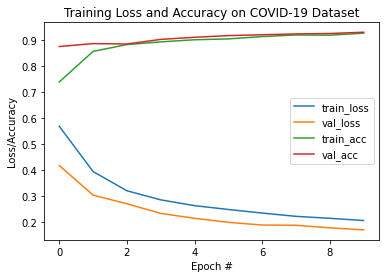

In [29]:
# graph for visual representation
plt.plot(np.arange(0, EPOCHS), head.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.show()